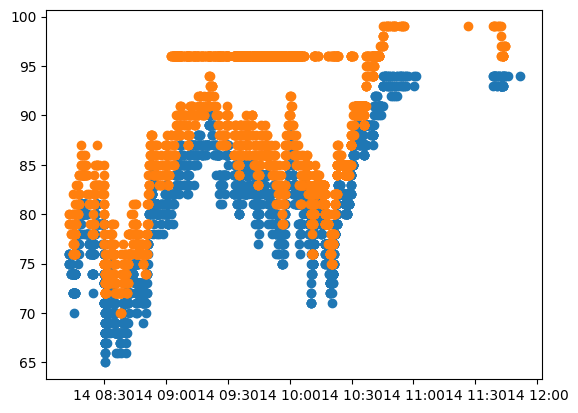

In [23]:
# Plot a market
import matplotlib.pyplot as plt 
data = db.read("INXZ-23SEP14-T4467.44")
ob = [i for i in data]
bbos = [(o.get_bbo(), o.ts) for o in ob]
bids = [(o.bid,ts) for o,ts in bbos if o is not None]
bids = [(o.price, ts) for o, ts in bids if o is not None]
asks =  [(o.ask,ts) for o,ts in bbos if o is not None]
asks = [(o.price,ts) for o,ts in asks if o is not None]
plt.scatter([ts for _, ts in bids], [p for p, _ in bids])
plt.scatter([ts for _, ts in asks], [p for p, _ in asks])
plt.show()

In [1]:
import datetime
####### START HERE ############
from data.coledb.coledb import ColeDBInterface
date = "2023-11-30"
end_time = "16:00:00"  # 4 pm
datetime_str = f"{date} {end_time}"
dt_object = datetime.datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
formatted_date = dt_object.strftime('%y%b%d').upper()
close_time_unix = int(dt_object.timestamp())
filename = f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/bbo_INXZ_and_SPY_{date}.csv"
from data.coledb.coledb import ColeDBInterface
db = ColeDBInterface()
cole_db_path = db.cole_db_storage_path / f"INXZ/{formatted_date}"
market_suffix = list(cole_db_path.iterdir())[0].name
price_threshold = float(market_suffix[1:])*10

In [88]:
# Create file ONLY RUN THIS ONCE
assert False
from strategy.utils import get_spy_ob_bbo_merged_df
from helpers.types.markets import MarketTicker
date_no_hyphen = date.replace("-","")
df = get_spy_ob_bbo_merged_df(db, f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/databento/xnas-itch/spy/xnas-itch-{date_no_hyphen}.mbo.csv", MarketTicker(f"INXZ-{formatted_date}-{market_suffix}"))
df.to_csv(filename)

AssertionError: 

1. first clean data, remove rows with nan spy. Then, divide spy price by 10000000 (to convert to cents). Take all times between 9:30 AM an d 4 PM
2. lag ES data by certain amount of time (maybe 0 seconds, 500 millis, 1 second, 2 seconds, 3 seconds, 4 seconds, 5 seconds, 10 seconds)
3. for each lagged df, tune hyper params 
4. params to tune are: m,b, and shift_up

In [2]:

# Load data (instead of creating)
import pandas as pd

# LOAD DATA
df = pd.read_csv(filename)

# First remove any rows with nan spy (cleaned_df)
cdf = df[df['spy_price'].notna()]
cdf['spy_price'] /= 10000000
cdf = cdf[(cdf.ts >= close_time_unix - 23400) & (cdf.ts <= close_time_unix)]
cdf = cdf[((cdf.yes_bid_price).notna()) & ((cdf.yes_ask_price).notna())]
cdf['spy_price_expanding_std_dev'] = cdf.spy_price.expanding().std()
# Next (skipped) lag the data
...


/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1365/1883981032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['spy_price'] /= 10000000


Ellipsis

In [23]:
import numpy as np
from scipy.optimize import basinhopping, minimize


def get_cdf_with_params(x):
    m = x[0]
    b = x[1]
    shift_up = x[2]
    c = x[3]
    d = x[4]
    """Minimization functions for the bids"""
    cdf['w'] = m *(close_time_unix - df.ts) + b
    cdf['sigmoid'] = (1 / (1 + np.exp(-1*(price_threshold - cdf.spy_price)*c + (cdf.w) * cdf.spy_price_expanding_std_dev))) + shift_up
    return cdf

def minimize_bids(x):
    cdf = get_cdf_with_params(x)
    # Adjust below for bids (yes_ask_price)
    return abs((100*cdf.sigmoid) - cdf.yes_bid_price).sum()
def callback(x, f=None, accepted= None):
    print(f"Iteration {callback.iteration}: x = {x}, f(x) = {f}, accepted = {accepted}")
    callback.iteration += 1
callback.iteration = 0
# Nelder-Mean method
result = minimize(
        minimize_bids,
        [-1.26921421e-04,  2.21516983e-01,  8.14942902e-03, -9.63582632e-03,  -3.02836067e-02],
        method="Nelder-Mead",
        callback=callback

    )
# Basin-hopping
# result = basinhopping(
#         minimize_bids,
#         [-1.84779063e-07, -4.70240335e-04, -4.52495123e-01],
#         stepsize=0.1,
#         callback=callback
#     )
# Best so far:
# 9/14/23 -- 104577
# [ 1.02845582e-04 -8.54036100e-01 -5.96145202e-02 -1.53017282e-02 -3.02836067e-02]
# 10/02/23 -- 456965
# [-1.56539662e-04  2.13745110e+00 -4.66691397e-02 -6.30269996e-03 -1.24675104e-02]
# 10/18/23 -- 170952
# [-1.26921421e-04,  2.21516983e-01,  8.14942902e-03, -9.63582632e-03,  -3.02836067e-02]
# 11/30/23 -- 982024.3783754266
# [-9.70465888e-06 -4.46854177e-01 -9.74987468e-02 -1.21413514e-02 -3.41819008e-03]
minimize_bids(result.x)

Iteration 0: x = [-1.14229279e-04  2.28162492e-01  8.39391189e-03 -9.92490111e-03
 -3.11921149e-02], f(x) = None, accepted = None
Iteration 1: x = [-1.14229279e-04  2.28162492e-01  8.39391189e-03 -9.92490111e-03
 -3.11921149e-02], f(x) = None, accepted = None
Iteration 2: x = [-1.14229279e-04  2.28162492e-01  8.39391189e-03 -9.92490111e-03
 -3.11921149e-02], f(x) = None, accepted = None
Iteration 3: x = [-1.11995462e-04  2.42357301e-01  8.32936841e-03 -9.57107357e-03
 -2.91958195e-02], f(x) = None, accepted = None
Iteration 4: x = [-1.03039886e-04  2.54861491e-01  8.43733205e-03 -9.53222192e-03
 -3.15715079e-02], f(x) = None, accepted = None
Iteration 5: x = [-1.03039886e-04  2.54861491e-01  8.43733205e-03 -9.53222192e-03
 -3.15715079e-02], f(x) = None, accepted = None
Iteration 6: x = [-8.66266113e-05  2.61829246e-01  8.11629931e-03 -1.03557721e-02
 -3.06489094e-02], f(x) = None, accepted = None
Iteration 7: x = [-7.07757708e-05  2.74391393e-01  9.15193553e-03 -1.01355868e-02
 -2.9278

1080324.6334477272

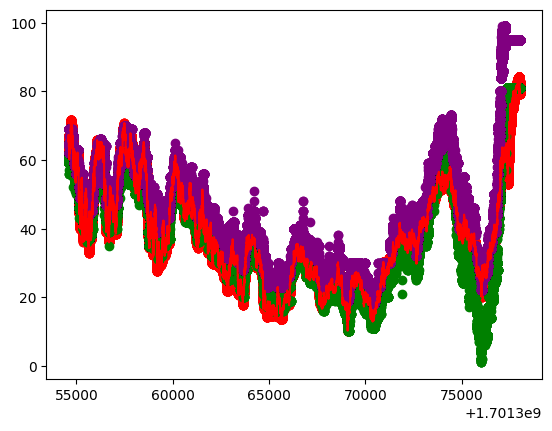

In [4]:
import matplotlib.pyplot as plt 
cdf_with_params = get_cdf_with_params(result.x)

plt.plot(cdf_with_params.ts, cdf_with_params.sigmoid*100, color = 'red')
plt.scatter(cdf_with_params.ts, cdf_with_params.sigmoid*100, color = 'red')
plt.scatter(cdf_with_params.ts, cdf_with_params.yes_bid_price, color ='green')
plt.scatter(cdf_with_params.ts, cdf_with_params.yes_ask_price, color = 'purple')
plt.show()

##### TODO:

1. (done) Figure out good bounds for hyper params -- it's returning the same values everywhere (find out why). You might need to use diff optimizations
2. **TODO** figure out why it's inversely correlated
3. Run for asks as well 
4. Finally, try to lag the data some time 